# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Process Analysis`*

---
*@author: Evan*\
*@date: 2023-05-09*

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [2]:
pa=xr.open_dataset('F:/Data/case_anqing/April/April_PA1.nc')
pa

<xarray.Dataset>
Dimensions:    (time: 720, level: 38, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 135.8 101.5 72.89
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    HADV_O3    (time, level, y, x) float32 ...
    ZADV_O3    (time, level, y, x) float32 ...
    HDIF_O3    (time, level, y, x) float32 ...
    VDIF_O3    (time, level, y, x) float32 ...
    DDEP_O3    (time, level, y, x) float32 ...
    CHEM_O3    (time, level, y, x) float32 ...
    HNO3prod   (time, level, y, x) float32 ...
    H2O2prod   (time, level, y, x) float32 ...
    O3prod     (time, level, y, x) float32 ...
    O3loss     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [6]:
HADV = pa.HADV_O3
ZADV = pa.ZADV_O3
HDIF = pa.HDIF_O3
VDIF = pa.VDIF_O3
DDEP = pa.DDEP_O3
CHEM = pa.CHEM_O3

In [7]:
import geopandas as gpd
shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)
for i in range(np.size(pa.latitude,0)):
    for j in range(np.size(pa.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],pa.longitude[i,j],pa.latitude[i,j])==False:
            HADV[:,:,i,j] = np.nan
            ZADV[:,:,i,j] = np.nan
            HDIF[:,:,i,j] = np.nan
            VDIF[:,:,i,j] = np.nan
            DDEP[:,:,i,j] = np.nan
            CHEM[:,:,i,j] = np.nan
            
hadv = np.nanmean(np.nanmean(HADV,2),2)
zadv = np.nanmean(np.nanmean(ZADV,2),2)
hdif = np.nanmean(np.nanmean(HDIF,2),2)
vdif = np.nanmean(np.nanmean(VDIF,2),2)
ddep = np.nanmean(np.nanmean(DDEP,2),2)
chem = np.nanmean(np.nanmean(CHEM,2),2)

分别提取白天和夜晚数据后求平均，白天：6-18h

In [10]:
day_index=np.arange(6,18)
night_index=np.array([0,1,2,3,4,7,18,19,20,21,22,23])
days=[]
nights=[]
for i in range(30):
    days=np.append(days,day_index+24*i)
    nights=np.append(nights,night_index+24*i)

print(days.shape, nights.shape)

(360,) (360,)


In [39]:
# 定义数组名称列表
arrays = ['hadv', 'zadv', 'hdif', 'vdif', 'ddep', 'chem']
nlevel=28

#! 使用循环将各个数组的日夜分离、正负分离
for array in arrays:
    # 根据数组名称获得对应的数组
    current_array = locals()[array][:,:nlevel]
    # 创建新的数组名称并将其添加到局部变量中
    for time_of_day in ['day', 'night']:
        new_array_name = f"{array}_{time_of_day}"
        locals()[new_array_name] = np.mean(current_array[days.astype(int) if time_of_day == 'day' else nights.astype(int), :].reshape(30, 12, nlevel),1)
        
        new_array_pos_name = f"{array}_{time_of_day}_pos"
        locals()[new_array_pos_name] = np.maximum(0, locals()[new_array_name])
        new_array_neg_name = f"{array}_{time_of_day}_neg"
        locals()[new_array_neg_name] = np.minimum(0, locals()[new_array_name])
hadv_day_pos.shape

(30, 28)

## 绘图

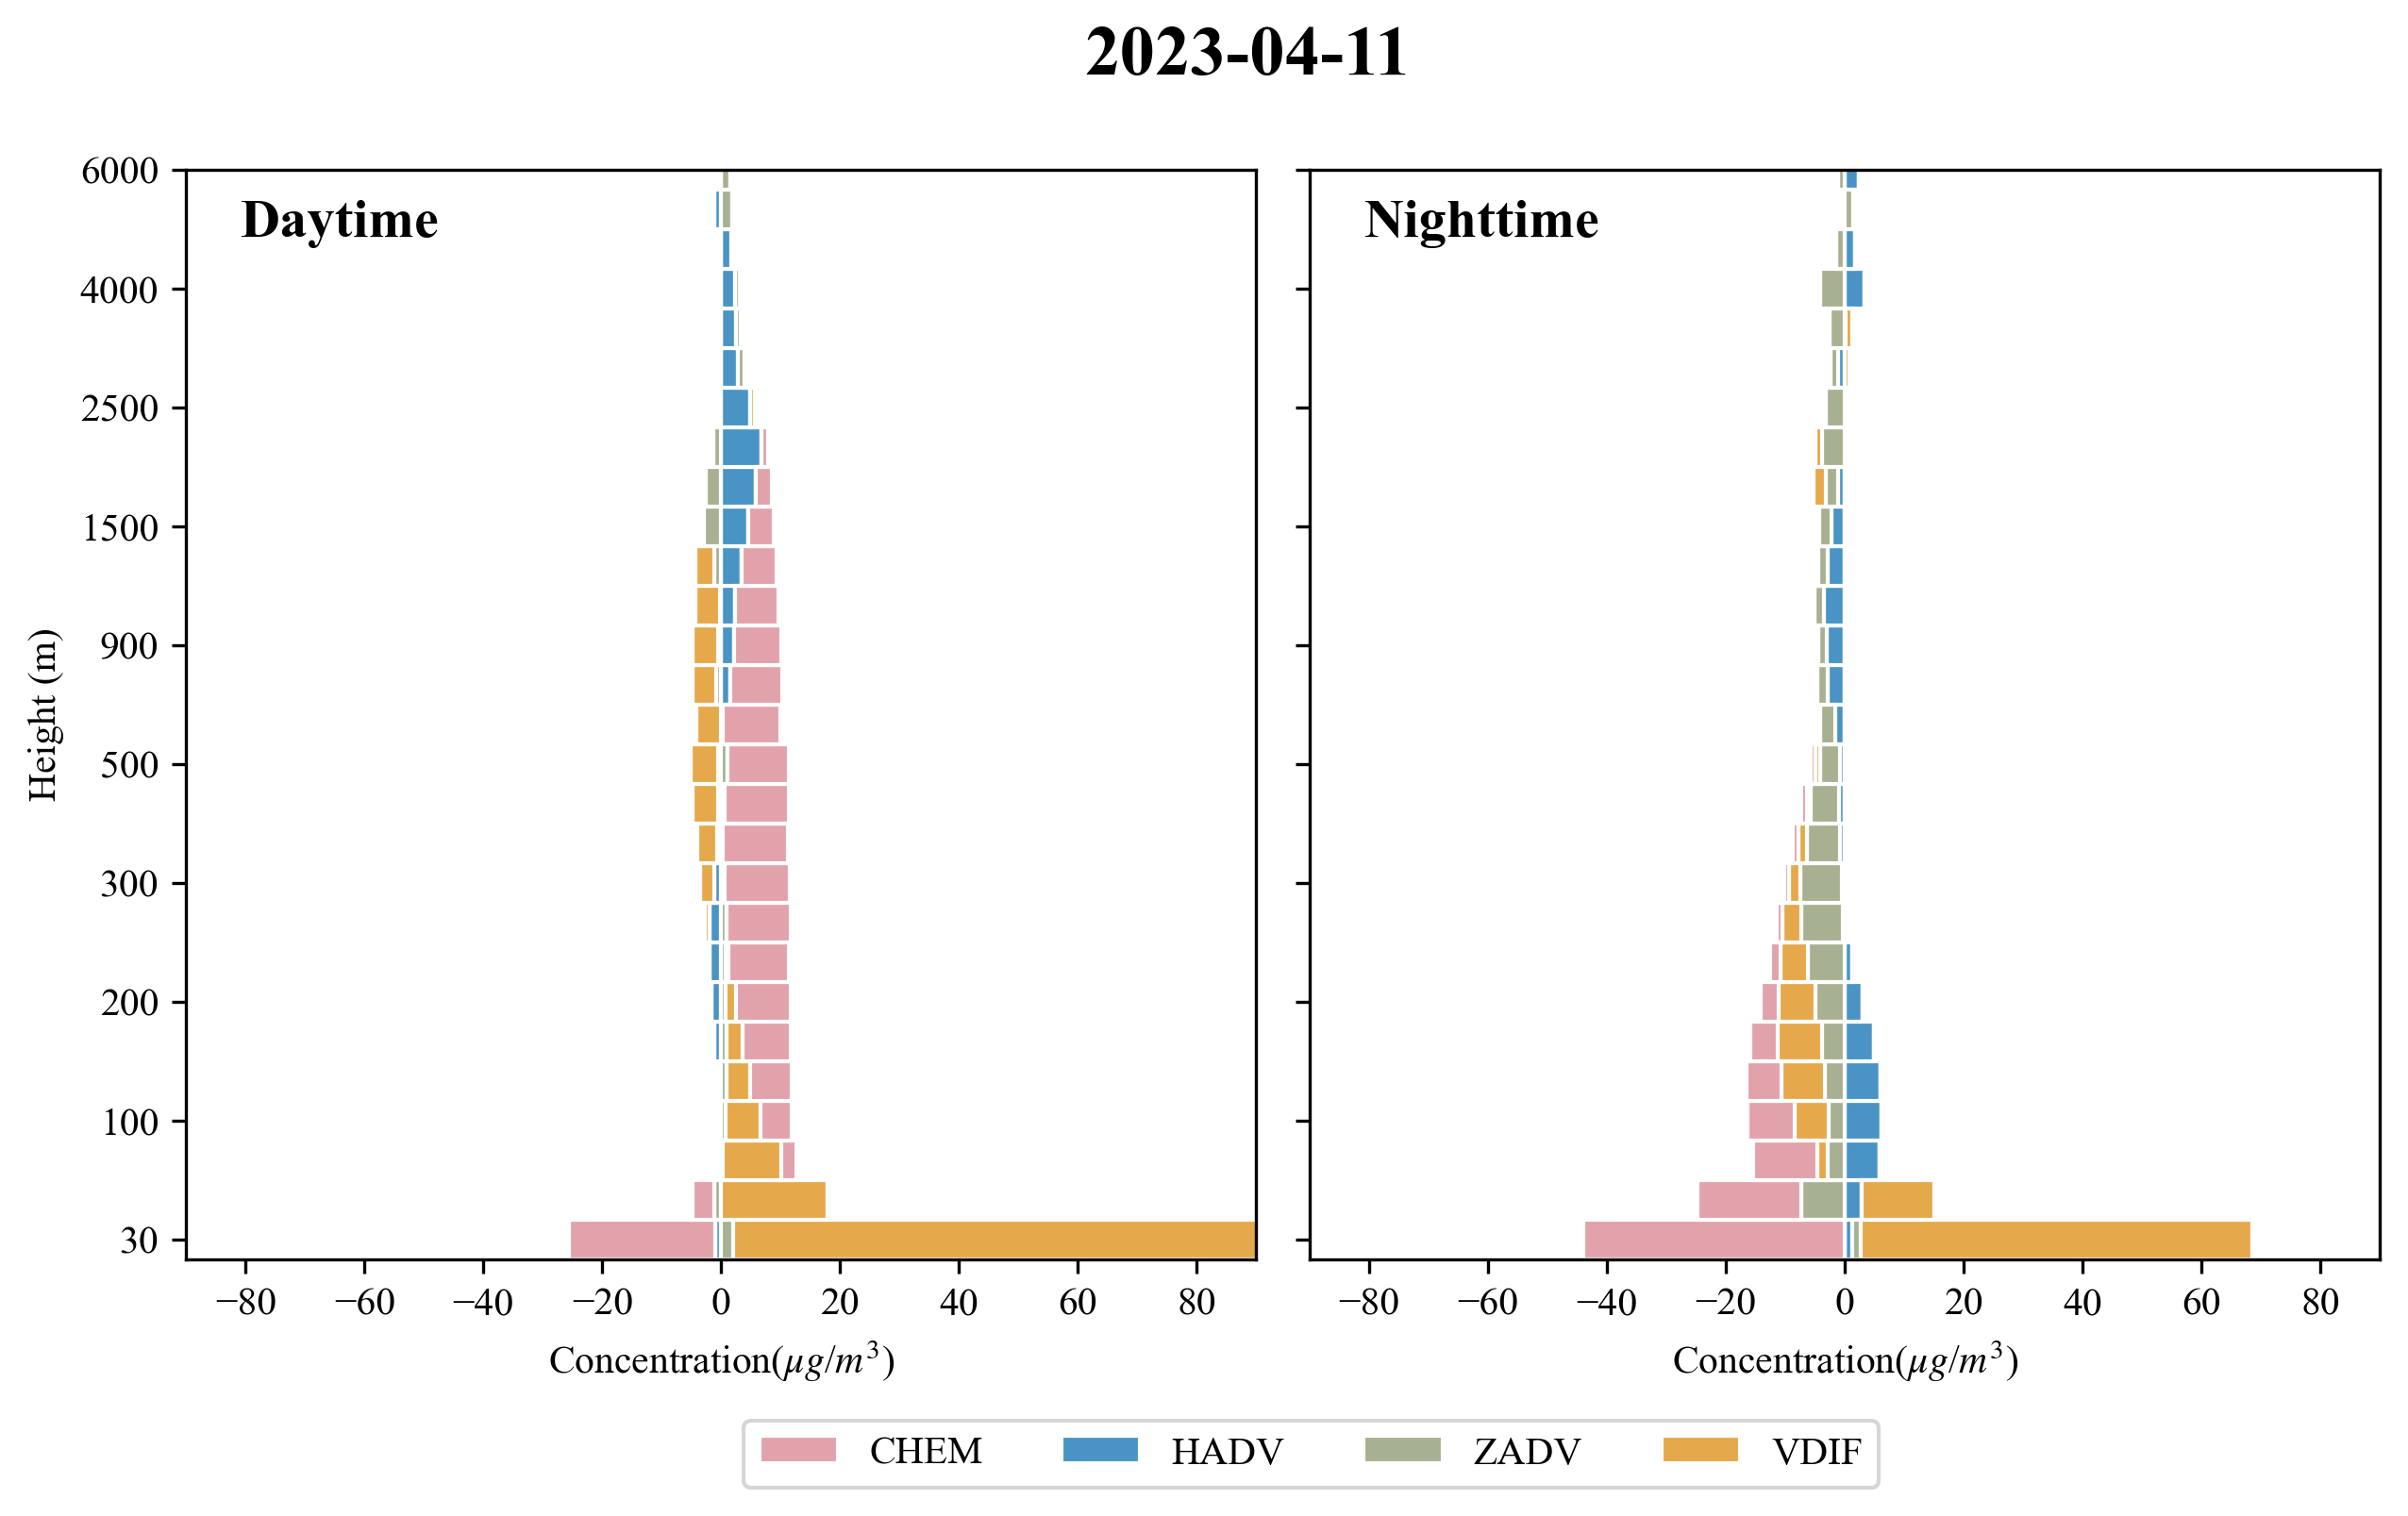

In [62]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'

daysel = 10
hadv_dp = hadv_day_pos[daysel,:]
hadv_dn = hadv_day_neg[daysel,:]
hadv_np = hadv_night_pos[daysel,:]
hadv_nn = hadv_night_neg[daysel,:]

zadv_dp = zadv_day_pos[daysel,:]
zadv_dn = zadv_day_neg[daysel,:]
zadv_np = zadv_night_pos[daysel,:]
zadv_nn = zadv_night_neg[daysel,:]

vdif_dp = vdif_day_pos[daysel,:]
vdif_dn = vdif_day_neg[daysel,:]
vdif_np = vdif_night_pos[daysel,:]
vdif_nn = vdif_night_neg[daysel,:]

chem_dp = chem_day_pos[daysel,:]
chem_dn = chem_day_neg[daysel,:]
chem_np = chem_night_pos[daysel,:]
chem_nn = chem_night_neg[daysel,:]

# ========================================================================================
fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,hadv_dp,color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,hadv_dn,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,zadv_dp,color=color_zadv,left=hadv_dp,height=1,edgecolor=edgec)
ax[0].barh(h,zadv_dn,color=color_zadv,left=hadv_dn,height=1,edgecolor=edgec)

b4=ax[0].barh(h,vdif_dp,color=color_vdif,left=hadv_dp+zadv_dp,height=1,edgecolor=edgec)
ax[0].barh(h,vdif_dn,color=color_vdif,left=hadv_dn+zadv_dn,height=1,edgecolor=edgec)

b5=ax[0].barh(h,chem_dp,color=color_chem,left=hadv_dp+zadv_dp+vdif_dp,
            height=1,edgecolor=edgec)
ax[0].barh(h,chem_dn,color=color_chem,left=hadv_dn+zadv_dn+vdif_dn,
            height=1,edgecolor=edgec)

ax[0].set_xlim(-90,90)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-80,81,20))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,hadv_np,color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,hadv_nn,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,zadv_np,color=color_zadv,left=hadv_np,height=1,edgecolor=edgec)
ax[1].barh(h,zadv_nn,color=color_zadv,left=hadv_nn,height=1,edgecolor=edgec)

b4=ax[1].barh(h,vdif_np,color=color_vdif,left=hadv_np+zadv_np,height=1,edgecolor=edgec)
ax[1].barh(h,vdif_nn,color=color_vdif,left=hadv_nn+zadv_nn,height=1,edgecolor=edgec)

b5=ax[1].barh(h,chem_np,color=color_chem,left=hadv_np+zadv_np+vdif_np,
            height=1,edgecolor=edgec)
ax[1].barh(h,chem_nn,color=color_chem,left=hadv_nn+zadv_nn+vdif_nn,
            height=1,edgecolor=edgec)

ax[1].set_xlim(-90,90)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b4),('CHEM','HADV','ZADV','VDIF'),bbox_to_anchor=(1.6,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle(pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'),
             fontsize=18,fontweight='bold')
plt.show()

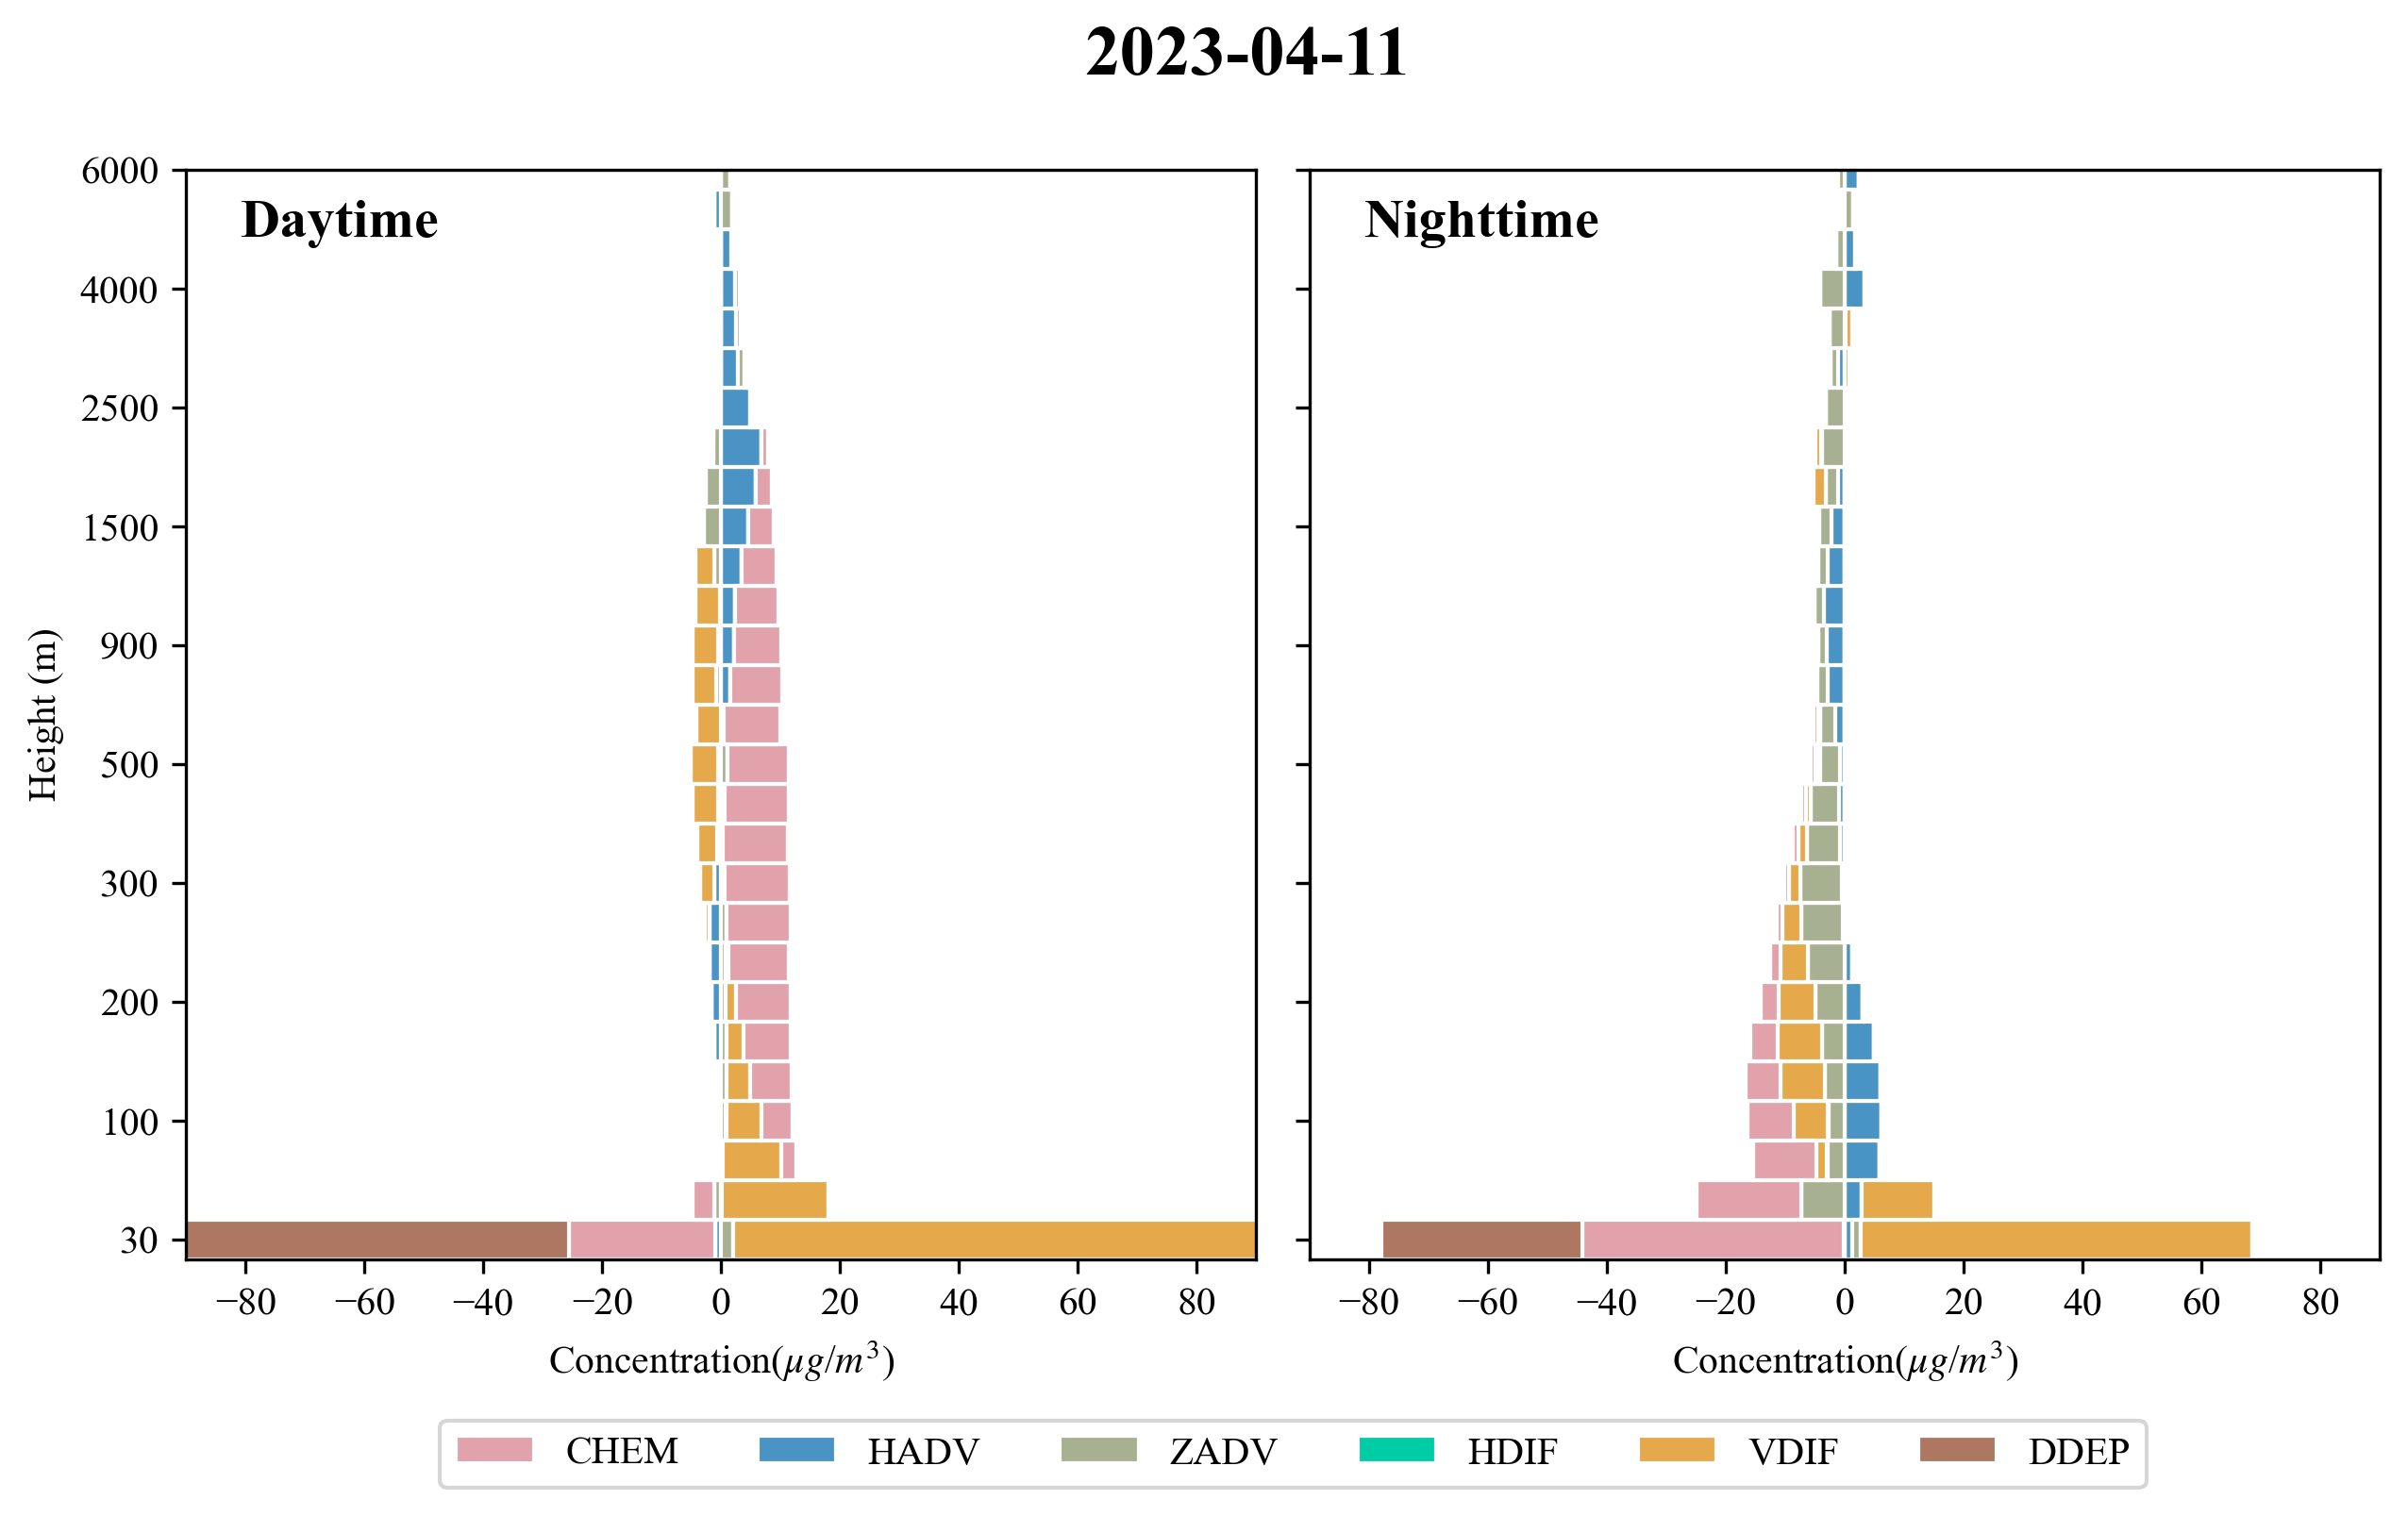

In [72]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

daysel = 10
hadv_dp = hadv_day_pos[daysel,:]
hadv_dn = hadv_day_neg[daysel,:]
hadv_np = hadv_night_pos[daysel,:]
hadv_nn = hadv_night_neg[daysel,:]

zadv_dp = zadv_day_pos[daysel,:]
zadv_dn = zadv_day_neg[daysel,:]
zadv_np = zadv_night_pos[daysel,:]
zadv_nn = zadv_night_neg[daysel,:]

hdif_dp = hdif_day_pos[daysel,:]
hdif_dn = hdif_day_neg[daysel,:]
hdif_np = hdif_night_pos[daysel,:]
hdif_nn = hdif_night_neg[daysel,:]

vdif_dp = vdif_day_pos[daysel,:]
vdif_dn = vdif_day_neg[daysel,:]
vdif_np = vdif_night_pos[daysel,:]
vdif_nn = vdif_night_neg[daysel,:]

chem_dp = chem_day_pos[daysel,:]
chem_dn = chem_day_neg[daysel,:]
chem_np = chem_night_pos[daysel,:]
chem_nn = chem_night_neg[daysel,:]

ddep_dp = ddep_day_pos[daysel,:]
ddep_dn = ddep_day_neg[daysel,:]
ddep_np = ddep_night_pos[daysel,:]
ddep_nn = ddep_night_neg[daysel,:]

# ========================================================================================
fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,hadv_dp,color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,hadv_dn,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,zadv_dp,color=color_zadv,left=hadv_dp,height=1,edgecolor=edgec)
ax[0].barh(h,zadv_dn,color=color_zadv,left=hadv_dn,height=1,edgecolor=edgec)

b3=ax[0].barh(h,hdif_dp,color=color_hdif,left=hadv_dp+zadv_dp,height=1,edgecolor=edgec)
ax[0].barh(h,hdif_dn,color=color_hdif,left=hadv_dn+zadv_dn,height=1,edgecolor=edgec)

b4=ax[0].barh(h,vdif_dp,color=color_vdif,left=hadv_dp+zadv_dp+hdif_dp,height=1,edgecolor=edgec)
ax[0].barh(h,vdif_dn,color=color_vdif,left=hadv_dn+zadv_dn+hdif_dn,height=1,edgecolor=edgec)

b5=ax[0].barh(h,chem_dp,color=color_chem,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp,
            height=1,edgecolor=edgec)
ax[0].barh(h,chem_dn,color=color_chem,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn,
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,ddep_dp,color=color_ddep,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp+chem_dp,
            height=1,edgecolor=edgec)
ax[0].barh(h,ddep_dn,color=color_ddep,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn+chem_dn,
            height=1,edgecolor=edgec)

ax[0].set_xlim(-90,90)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-80,81,20))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,hadv_np,color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,hadv_nn,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,zadv_np,color=color_zadv,left=hadv_np,height=1,edgecolor=edgec)
ax[1].barh(h,zadv_nn,color=color_zadv,left=hadv_nn,height=1,edgecolor=edgec)

b3=ax[1].barh(h,hdif_np,color=color_hdif,left=hadv_np+zadv_np,height=1,edgecolor=edgec)
ax[1].barh(h,hdif_nn,color=color_hdif,left=hadv_nn+zadv_nn,height=1,edgecolor=edgec)

b4=ax[1].barh(h,vdif_np,color=color_vdif,left=hadv_np+zadv_np+hdif_np,height=1,edgecolor=edgec)
ax[1].barh(h,vdif_nn,color=color_vdif,left=hadv_nn+zadv_nn+hdif_nn,height=1,edgecolor=edgec)

b5=ax[1].barh(h,chem_np,color=color_chem,left=hadv_np+zadv_np+vdif_np+hdif_np,
            height=1,edgecolor=edgec)
ax[1].barh(h,chem_nn,color=color_chem,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn,
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,ddep_np,color=color_ddep,left=hadv_np+zadv_np+vdif_np+hdif_np+chem_np,
            height=1,edgecolor=edgec)
ax[1].barh(h,ddep_nn,color=color_ddep,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn+chem_nn,
            height=1,edgecolor=edgec)

ax[1].set_xlim(-90,90)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle(pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'),
             fontsize=18,fontweight='bold')
plt.show()

In [73]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

dates = np.arange(0,30)
for daysel in dates:
    hadv_dp = hadv_day_pos[daysel,:]
    hadv_dn = hadv_day_neg[daysel,:]
    hadv_np = hadv_night_pos[daysel,:]
    hadv_nn = hadv_night_neg[daysel,:]

    zadv_dp = zadv_day_pos[daysel,:]
    zadv_dn = zadv_day_neg[daysel,:]
    zadv_np = zadv_night_pos[daysel,:]
    zadv_nn = zadv_night_neg[daysel,:]

    hdif_dp = hdif_day_pos[daysel,:]
    hdif_dn = hdif_day_neg[daysel,:]
    hdif_np = hdif_night_pos[daysel,:]
    hdif_nn = hdif_night_neg[daysel,:]

    vdif_dp = vdif_day_pos[daysel,:]
    vdif_dn = vdif_day_neg[daysel,:]
    vdif_np = vdif_night_pos[daysel,:]
    vdif_nn = vdif_night_neg[daysel,:]

    chem_dp = chem_day_pos[daysel,:]
    chem_dn = chem_day_neg[daysel,:]
    chem_np = chem_night_pos[daysel,:]
    chem_nn = chem_night_neg[daysel,:]

    ddep_dp = ddep_day_pos[daysel,:]
    ddep_dn = ddep_day_neg[daysel,:]
    ddep_np = ddep_night_pos[daysel,:]
    ddep_nn = ddep_night_neg[daysel,:]

    # ========================================================================================
    fig = plt.figure(figsize=(10,5),dpi=300)
    ax  = fig.subplots(1,2,sharey=True,sharex=True)

    b1=ax[0].barh(h,hadv_dp,color=color_hadv,height=1,edgecolor=edgec)
    ax[0].barh(h,hadv_dn,color=color_hadv,height=1,edgecolor=edgec)

    b2=ax[0].barh(h,zadv_dp,color=color_zadv,left=hadv_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,zadv_dn,color=color_zadv,left=hadv_dn,height=1,edgecolor=edgec)

    b3=ax[0].barh(h,hdif_dp,color=color_hdif,left=hadv_dp+zadv_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,hdif_dn,color=color_hdif,left=hadv_dn+zadv_dn,height=1,edgecolor=edgec)

    b4=ax[0].barh(h,vdif_dp,color=color_vdif,left=hadv_dp+zadv_dp+hdif_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,vdif_dn,color=color_vdif,left=hadv_dn+zadv_dn+hdif_dn,height=1,edgecolor=edgec)

    b5=ax[0].barh(h,chem_dp,color=color_chem,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp,
                height=1,edgecolor=edgec)
    ax[0].barh(h,chem_dn,color=color_chem,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn,
                height=1,edgecolor=edgec)

    b6=ax[0].barh(h,ddep_dp,color=color_ddep,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp+chem_dp,
                height=1,edgecolor=edgec)
    ax[0].barh(h,ddep_dn,color=color_ddep,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn+chem_dn,
                height=1,edgecolor=edgec)

    ax[0].set_xlim(-90,90)
    ax[0].set_ylim(-0.5,27)
    ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
    # ax[0].set_ylabel('Pressure (hPa)')
    ax[0].set_ylabel('Height (m)')
    ax[0].set_xticks(np.arange(-80,81,20))
    ax[0].set_yticks(np.arange(0,28,3))
    ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
    # ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
    ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

    # ========================================================================================

    b1=ax[1].barh(h,hadv_np,color=color_hadv,height=1,edgecolor=edgec)
    ax[1].barh(h,hadv_nn,color=color_hadv,height=1,edgecolor=edgec)

    b2=ax[1].barh(h,zadv_np,color=color_zadv,left=hadv_np,height=1,edgecolor=edgec)
    ax[1].barh(h,zadv_nn,color=color_zadv,left=hadv_nn,height=1,edgecolor=edgec)

    b3=ax[1].barh(h,hdif_np,color=color_hdif,left=hadv_np+zadv_np,height=1,edgecolor=edgec)
    ax[1].barh(h,hdif_nn,color=color_hdif,left=hadv_nn+zadv_nn,height=1,edgecolor=edgec)

    b4=ax[1].barh(h,vdif_np,color=color_vdif,left=hadv_np+zadv_np+hdif_np,height=1,edgecolor=edgec)
    ax[1].barh(h,vdif_nn,color=color_vdif,left=hadv_nn+zadv_nn+hdif_nn,height=1,edgecolor=edgec)

    b5=ax[1].barh(h,chem_np,color=color_chem,left=hadv_np+zadv_np+vdif_np+hdif_np,
                height=1,edgecolor=edgec)
    ax[1].barh(h,chem_nn,color=color_chem,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn,
                height=1,edgecolor=edgec)

    b6=ax[1].barh(h,ddep_np,color=color_ddep,left=hadv_np+zadv_np+vdif_np+hdif_np+chem_np,
                height=1,edgecolor=edgec)
    ax[1].barh(h,ddep_nn,color=color_ddep,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn+chem_nn,
                height=1,edgecolor=edgec)

    ax[1].set_xlim(-90,90)
    ax[1].set_ylim(-0.5,27)
    ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
    ax[1].set_yticks(np.arange(0,28,3))
    ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

    ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    plt.suptitle(pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'),
                fontsize=18,fontweight='bold')
    plt.savefig('D:/Download/PA_'+pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'))
    print('saving PA on '+pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'))
    plt.close()

saving PA on 2023-04-01
saving PA on 2023-04-02
saving PA on 2023-04-03
saving PA on 2023-04-04
saving PA on 2023-04-05
saving PA on 2023-04-06
saving PA on 2023-04-07
saving PA on 2023-04-08
saving PA on 2023-04-09
saving PA on 2023-04-10
saving PA on 2023-04-11
saving PA on 2023-04-12
saving PA on 2023-04-13
saving PA on 2023-04-14
saving PA on 2023-04-15
saving PA on 2023-04-16
saving PA on 2023-04-17
saving PA on 2023-04-18
saving PA on 2023-04-19
saving PA on 2023-04-20
saving PA on 2023-04-21
saving PA on 2023-04-22
saving PA on 2023-04-23
saving PA on 2023-04-24
saving PA on 2023-04-25
saving PA on 2023-04-26
saving PA on 2023-04-27
saving PA on 2023-04-28
saving PA on 2023-04-29
saving PA on 2023-04-30


调整x轴的范围

In [74]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

dates = np.arange(0,30)
for daysel in dates:
    hadv_dp = hadv_day_pos[daysel,:]
    hadv_dn = hadv_day_neg[daysel,:]
    hadv_np = hadv_night_pos[daysel,:]
    hadv_nn = hadv_night_neg[daysel,:]

    zadv_dp = zadv_day_pos[daysel,:]
    zadv_dn = zadv_day_neg[daysel,:]
    zadv_np = zadv_night_pos[daysel,:]
    zadv_nn = zadv_night_neg[daysel,:]

    hdif_dp = hdif_day_pos[daysel,:]
    hdif_dn = hdif_day_neg[daysel,:]
    hdif_np = hdif_night_pos[daysel,:]
    hdif_nn = hdif_night_neg[daysel,:]

    vdif_dp = vdif_day_pos[daysel,:]
    vdif_dn = vdif_day_neg[daysel,:]
    vdif_np = vdif_night_pos[daysel,:]
    vdif_nn = vdif_night_neg[daysel,:]

    chem_dp = chem_day_pos[daysel,:]
    chem_dn = chem_day_neg[daysel,:]
    chem_np = chem_night_pos[daysel,:]
    chem_nn = chem_night_neg[daysel,:]

    ddep_dp = ddep_day_pos[daysel,:]
    ddep_dn = ddep_day_neg[daysel,:]
    ddep_np = ddep_night_pos[daysel,:]
    ddep_nn = ddep_night_neg[daysel,:]

    # ========================================================================================
    fig = plt.figure(figsize=(10,5),dpi=300)
    ax  = fig.subplots(1,2,sharey=True,sharex=True)

    b1=ax[0].barh(h,hadv_dp,color=color_hadv,height=1,edgecolor=edgec)
    ax[0].barh(h,hadv_dn,color=color_hadv,height=1,edgecolor=edgec)

    b2=ax[0].barh(h,zadv_dp,color=color_zadv,left=hadv_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,zadv_dn,color=color_zadv,left=hadv_dn,height=1,edgecolor=edgec)

    b3=ax[0].barh(h,hdif_dp,color=color_hdif,left=hadv_dp+zadv_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,hdif_dn,color=color_hdif,left=hadv_dn+zadv_dn,height=1,edgecolor=edgec)

    b4=ax[0].barh(h,vdif_dp,color=color_vdif,left=hadv_dp+zadv_dp+hdif_dp,height=1,edgecolor=edgec)
    ax[0].barh(h,vdif_dn,color=color_vdif,left=hadv_dn+zadv_dn+hdif_dn,height=1,edgecolor=edgec)

    b5=ax[0].barh(h,chem_dp,color=color_chem,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp,
                height=1,edgecolor=edgec)
    ax[0].barh(h,chem_dn,color=color_chem,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn,
                height=1,edgecolor=edgec)

    b6=ax[0].barh(h,ddep_dp,color=color_ddep,left=hadv_dp+zadv_dp+vdif_dp+hdif_dp+chem_dp,
                height=1,edgecolor=edgec)
    ax[0].barh(h,ddep_dn,color=color_ddep,left=hadv_dn+zadv_dn+vdif_dn+hdif_dn+chem_dn,
                height=1,edgecolor=edgec)

    ax[0].set_xlim(-50,50)
    ax[0].set_ylim(-0.5,27)
    ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
    # ax[0].set_ylabel('Pressure (hPa)')
    ax[0].set_ylabel('Height (m)')
    ax[0].set_xticks(np.arange(-80,81,20))
    ax[0].set_yticks(np.arange(0,28,3))
    ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
    # ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
    ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

    # ========================================================================================

    b1=ax[1].barh(h,hadv_np,color=color_hadv,height=1,edgecolor=edgec)
    ax[1].barh(h,hadv_nn,color=color_hadv,height=1,edgecolor=edgec)

    b2=ax[1].barh(h,zadv_np,color=color_zadv,left=hadv_np,height=1,edgecolor=edgec)
    ax[1].barh(h,zadv_nn,color=color_zadv,left=hadv_nn,height=1,edgecolor=edgec)

    b3=ax[1].barh(h,hdif_np,color=color_hdif,left=hadv_np+zadv_np,height=1,edgecolor=edgec)
    ax[1].barh(h,hdif_nn,color=color_hdif,left=hadv_nn+zadv_nn,height=1,edgecolor=edgec)

    b4=ax[1].barh(h,vdif_np,color=color_vdif,left=hadv_np+zadv_np+hdif_np,height=1,edgecolor=edgec)
    ax[1].barh(h,vdif_nn,color=color_vdif,left=hadv_nn+zadv_nn+hdif_nn,height=1,edgecolor=edgec)

    b5=ax[1].barh(h,chem_np,color=color_chem,left=hadv_np+zadv_np+vdif_np+hdif_np,
                height=1,edgecolor=edgec)
    ax[1].barh(h,chem_nn,color=color_chem,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn,
                height=1,edgecolor=edgec)

    b6=ax[1].barh(h,ddep_np,color=color_ddep,left=hadv_np+zadv_np+vdif_np+hdif_np+chem_np,
                height=1,edgecolor=edgec)
    ax[1].barh(h,ddep_nn,color=color_ddep,left=hadv_nn+zadv_nn+vdif_nn+hdif_nn+chem_nn,
                height=1,edgecolor=edgec)

    ax[1].set_xlim(-50,50)
    ax[1].set_ylim(-0.5,27)
    ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
    ax[1].set_yticks(np.arange(0,28,3))
    ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

    ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    plt.suptitle(pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'),
                fontsize=18,fontweight='bold')
    plt.savefig('D:/Download/PA_'+pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'))
    print('saving PA on '+pd.to_datetime('2023-04-'+str(daysel+1)).strftime('%Y-%m-%d'))
    plt.close()

saving PA on 2023-04-01
saving PA on 2023-04-02
saving PA on 2023-04-03
saving PA on 2023-04-04
saving PA on 2023-04-05
saving PA on 2023-04-06
saving PA on 2023-04-07
saving PA on 2023-04-08
saving PA on 2023-04-09
saving PA on 2023-04-10
saving PA on 2023-04-11
saving PA on 2023-04-12
saving PA on 2023-04-13
saving PA on 2023-04-14
saving PA on 2023-04-15
saving PA on 2023-04-16
saving PA on 2023-04-17
saving PA on 2023-04-18
saving PA on 2023-04-19
saving PA on 2023-04-20
saving PA on 2023-04-21
saving PA on 2023-04-22
saving PA on 2023-04-23
saving PA on 2023-04-24
saving PA on 2023-04-25
saving PA on 2023-04-26
saving PA on 2023-04-27
saving PA on 2023-04-28
saving PA on 2023-04-29
saving PA on 2023-04-30
